# Hallucination Score Analysis

In this notebook, the hallucination scores of the methods are analyzed.

In [1]:
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import json


## Utility Functions

In [22]:
# LOADING
# load a dataframe from a file
def load_dataframe(f):
    dataset_name = f.split("__")[0].split("_")[-4]
    model_name = f.split(dataset_name)[0].split("\\")[-1] +"_"+ f.split("__")[-1].split(".")[0]
    df = pd.read_csv(f)
    df.drop([col for col in df.columns if "answer" in col or "prompt" in col], axis=1, inplace=True)
    durations_df = pd.read_csv(f.split(dataset_name)[0] + "durations.csv")
    return {"dataset_name": dataset_name, "model": model_name, "df": df, "durations": durations_df}
# --------------------------------

# PREPROCESSING
# fix json errors in the column lbhd_score
def fix_json_errors(df):
    print("Starting to fix JSON errors...")
    for index, row in df.iterrows():
        json_str = row['lbhd_score'].replace("'", "\"")
        while True:
            try:
                # Attempt to parse the JSON string
                json.loads(json_str)
                break  # Exit the loop if no error
            except json.JSONDecodeError as e:
                # If there's a JSONDecodeError, extract the position of the error
                error_pos = e.pos
                print(f"Fixing error in row {index} at position: {error_pos}")
                # Add a backslash to the string in front of the error to escape the character
                json_str = json_str[:error_pos - 1] + "\\" + json_str[error_pos - 1:]
                # Replace the JSON string in the DataFrame with the corrected one
                df.at[index, 'lbhd_score'] = json_str
    return df

# normalize the columns
def normalize_column(column):
    # Apply Min-Max normalization
    column = (column - column.min()) / (column.max() - column.min())
    return column

# process the lbhd_score column
def process_lbhd_scores(df):
    # Initialize new columns with default values
    df['lbhd_sent_avg'] = 0.0
    df['lbhd_sent_min'] = 0.0
    df['lbhd_sent_normalized_product'] = 0.0
    df['lbhd_concept_avg'] = 0.0
    df['lbhd_concept_min'] = 0.0
    df['lbhd_concept_normalized_product'] = 0.0
    # Iterate over each row to process the 'lbhd_score' column
    for index, row in df.iterrows():
        # Parse the string representation of the dictionary into an actual dictionary
        lbhd_score = json.loads(row['lbhd_score'].replace("'", "\""))        
        # Extract the low-level scores
        df.at[index, 'lbhd_sent_avg'] = lbhd_score['avg']
        df.at[index, 'lbhd_sent_min'] = lbhd_score['min']
        df.at[index, 'lbhd_sent_normalized_product'] = lbhd_score['normalized_product']        
        # Aggregate the concept-level scores
        concept_avgs = [concept[next(iter(concept))]['avg'] for concept in lbhd_score['concepts']]
        concept_mins = [concept[next(iter(concept))]['min'] for concept in lbhd_score['concepts']]
        concept_norm_prods = [concept[next(iter(concept))]['normalized_product'] for concept in lbhd_score['concepts']]        
        df.at[index, 'lbhd_concept_avg'] = np.mean(concept_avgs)
        df.at[index, 'lbhd_concept_min'] = np.min(concept_mins)
        def normalized_product(probabilities):
            adjusted_probs = [max(p, 1e-30) for p in probabilities]
            log_probs = np.log(adjusted_probs)
            score = np.exp(np.sum(log_probs) / len(adjusted_probs))
            return score
        df.at[index, 'lbhd_concept_normalized_product'] = normalized_product(concept_norm_prods)
    # Remove the 'lbhd_score' column
    df.drop('lbhd_score', axis=1, inplace=True)

    # Normalize the new columns
    df['lbhd_sent_avg'] = normalize_column(df['lbhd_sent_avg'])
    df['lbhd_sent_min'] = normalize_column(df['lbhd_sent_min'])
    df['lbhd_sent_normalized_product'] = normalize_column(df['lbhd_sent_normalized_product'])
    df['lbhd_concept_avg'] = normalize_column(df['lbhd_concept_avg'])
    df['lbhd_concept_min'] = normalize_column(df['lbhd_concept_min'])
    df['lbhd_concept_normalized_product'] = normalize_column(df['lbhd_concept_normalized_product'])
    # reverse calculation of: linear_probs = [(prob + 1) / 2 for prob in linear_probs]
    # for col in df.columns:
    #     if "lbhd" in col:
    #         df[col] = (df[col] * 2) - 1
    return df
# --------------------------------

# VISUALIZATION
def plot_correlation_ground_truth(df, model_name, dataset_name):
    # Ensure 'ground_truth' is the last column
    columns = [col for col in df.columns if col != 'ground_truth'] + ['ground_truth']
    df = df[columns]

    # Compute the correlation matrix
    corr = df.corr()

    # Isolate the 'ground_truth' row for the heatmap
    corr_ground_truth = corr.loc[['ground_truth'], :]

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(len(corr.columns), 2)) # Adjusted the size for just one row

    # Define custom colormap
    cmap = "YlGnBu"

    # Draw the heatmap for the 'ground_truth' row
    sns.heatmap(corr_ground_truth, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                annot=True, fmt=".2f", annot_kws={"size": 10}) # Adjusted annotation size for readability

    # Set ticks and labels
    ax.set_xticks(np.arange(len(corr.columns)) + .5)
    ax.set_yticks([0.5]) # Only one tick at the center of the 'ground_truth' row
    ax.set_xticklabels(corr.columns, rotation=45, ha="right")
    ax.set_yticklabels(['ground_truth']) # Only 'ground_truth' label is needed

    # Set title with model and dataset names
    dataset_name = "Natural Questions" if dataset_name == "nqopen" else "XSum" if dataset_name == "xsum" else dataset_name
    plt.title(f'Correlation with Ground Truth for {model_name}\non dataset {dataset_name}', fontsize=16, pad=20)

    # Adjust layout to fit everything
    plt.tight_layout()

    # Display the plot
    plt.show()


## Loading the scores

In [23]:
# load datasets
# find all csvs with scores and ground truths
files = glob.glob("results/*with_ground_truths*.csv")

# load all csvs into a list of dataframes
datasets = [load_dataframe(f) for f in files]

print(f"Found {len(datasets)} CSVs with scores and ground truths for analysis:\n")
for dataset in datasets:
    print(f"Dataset: {dataset['dataset_name']}")
    print(f"LLM: {dataset['model']}")
    print(f"Shape: {dataset['df'].shape}\n")

Found 4 CSVs with scores and ground truths for analysis:

Dataset: nqopen
LLM: togetherai_2__mistralai_Mistral-7B-Instruct-v0-1
Shape: (80, 6)

Dataset: xsum
LLM: togetherai_2__mistralai_Mistral-7B-Instruct-v0-1
Shape: (80, 6)

Dataset: nqopen
LLM: togetherai__mistralai_Mixtral-8x7B-Instruct-v0-1
Shape: (80, 6)

Dataset: xsum
LLM: togetherai__mistralai_Mixtral-8x7B-Instruct-v0-1
Shape: (80, 6)



In [24]:
test_df = datasets[0]["df"]
test_df.head(2)

,selfcheck_nli_score,selfcheck_bert_score,fleek_score,lm_v_lm_score,lbhd_score,ground_truth
0,0.810109,0.546060,0,0.0,"{'avg': 0.29954681108807507, 'normalized_produ...",1.0
1,0.998452,0.455366,0,0.0,"{'avg': 0.39881583601590387, 'normalized_produ...",1.0


In [25]:
# process LBHD scores
test_df = fix_json_errors(test_df)
test_df = process_lbhd_scores(test_df)   # aggregate concept-level scores and normalize (min-max)
test_df.head(10)

Starting to fix JSON errors...
Fixing error in row 1 at position: 325
Fixing error in row 1 at position: 434
Fixing error in row 35 at position: 393
Fixing error in row 57 at position: 236
Fixing error in row 59 at position: 336
Fixing error in row 60 at position: 216
Fixing error in row 76 at position: 354


,selfcheck_nli_score,selfcheck_bert_score,fleek_score,lm_v_lm_score,ground_truth,lbhd_sent_avg,lbhd_sent_min,lbhd_sent_normalized_product,lbhd_concept_avg,lbhd_concept_min,lbhd_concept_normalized_product
0,0.810109,0.546060,0,0.0,1.0,0.330865,0.544770,0.000024,0.716248,0.490450,0.000027
1,0.998452,0.455366,0,0.0,1.0,0.691431,0.360899,0.053218,0.862805,0.324913,0.020967
2,0.479305,0.604782,0,0.0,0.0,0.432280,0.821490,0.601628,0.650456,0.750257,0.548450
3,0.008632,0.363366,0,0.0,0.0,0.731092,0.870537,0.816808,0.869698,0.839084,0.829953
4,0.599977,0.345637,0,0.0,1.0,0.685218,0.294742,0.005004,0.728680,0.265352,0.000936
5,0.733930,0.376340,0,1.0,0.0,0.730294,0.623246,0.000192,0.779998,0.552475,0.000002
6,0.239289,0.538912,0,0.0,1.0,0.726075,0.737767,0.744811,0.782936,0.618608,0.002499
7,0.581818,0.538912,0,1.0,0.0,0.989744,1.000000,0.993125,0.984780,0.900288,0.977723
8,0.606773,0.512157,0,0.0,0.0,0.222909,0.382343,0.000027,0.328817,0.344219,0.000000
9,0.222154,0.453717,0,0.0,0.0,1.000000,0.981750,1.000000,1.000000,1.000000,1.000000


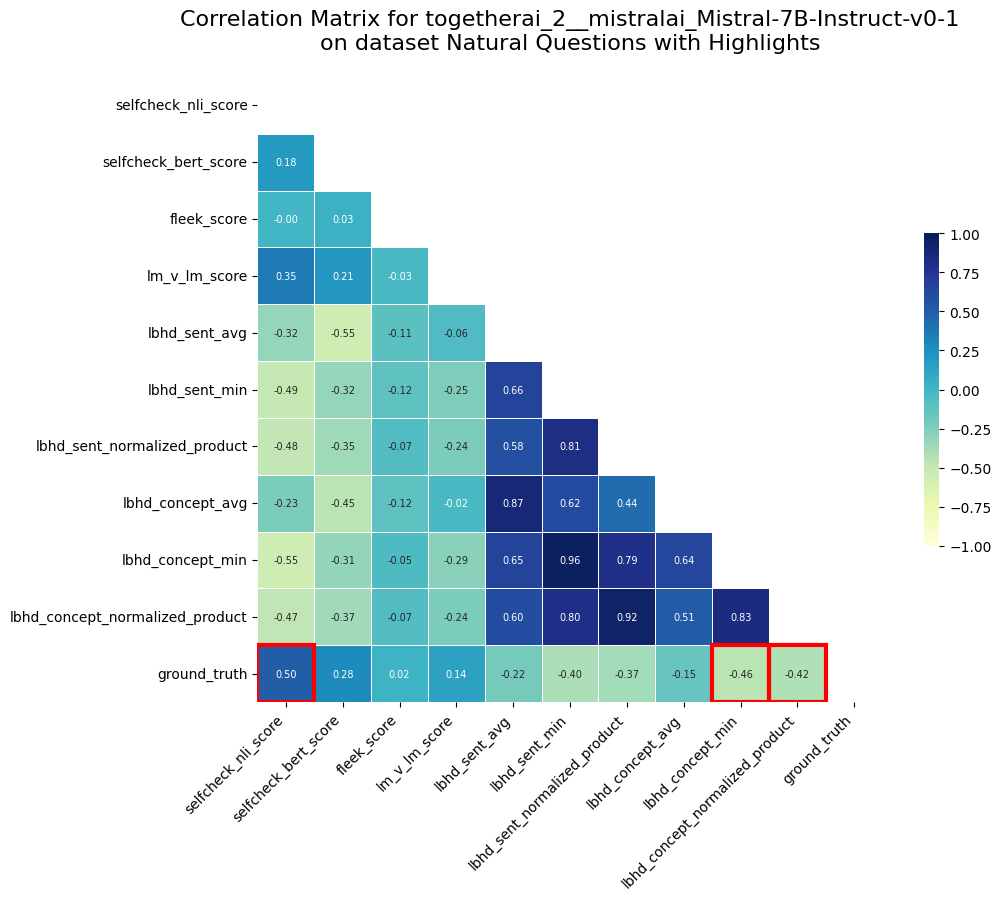

In [26]:
plot_correlation_matrix(test_df, datasets[0]["model"], datasets[0]["dataset_name"])